<h1><center>Analyzing Data-Science community Stack Exchange Data</center></h1>
<h3><center>Determine the most popular content on the Data-science community of Stack exchange</center></h3>

Stack Exchange is a network of question-and-answer websites on topics in diverse fields, each site covering a specific topic, where questions, answers, and users are subject to a reputation award process. The reputation system allows the sites to be self-moderating. <br>
Data Science Stack Exchange is a question-answer forum, to connect the Data Science community. Posts regarding Data Science - Machine Learning, Statistical Mathematics, Visualizations etc are mainly found here. Each post usually contains a question asked pertaining to above topics and attached are a string of answers.


The aim of this project is to analyze the following:-

* Questions posted on the data science community of Stack Exchange server in the 2019 year to determine the most popular topics among these post. 
* Trend in the popularity of deep learning topic over the years. 
    * Would it benefit the community to post on Deep learning?
    * What other topics can be paired with Deep learning for the posts?

The purpose of the analysis is to determine and write posts, to help the community, on topics that are most sought after in the data science community of Stack Exchange<br>
Stack Exchange hosts an open Database - <a href="https://data.stackexchange.com/datascience/query/new">Link</a>, the community can utilize. After analyzing the database, the table *Posts* is found relevant for the end goal. This is downloaded into the 2019_questions.csv file. The posts are of the year 2019 only.

The *Posts* table has the following attributes(columns) :<br>

    PostTypeId : id
    CreationDate : date the post was uploaded
    Score : the score of the post
    ViewCount : number of views
    Tags : tags associated with the posts
    AnswerCount : number of replies to the post
    FavoriteCount : number of likes recieved by the post

Out of the type of posts, we will mainly focus on the Questions and Answers. The other kind of posts are inconsequential.<br>

The database is queried for all questions & answers in 2019 with above columns, and stored in the csv file - 2019_questions.csv
For the second part of the analysis, all questions are downloaded into the all_questions.csv

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

The dataset is read into the environment with the `parse_dates` paramter so that the column *CreationDate* is automatically read in as a datetime object.

In [8]:
df = pd.read_csv('2019_questions.csv',parse_dates=['CreationDate'])

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8839 entries, 0 to 8838
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             8839 non-null   int64         
 1   CreationDate   8839 non-null   datetime64[ns]
 2   Score          8839 non-null   int64         
 3   ViewCount      8839 non-null   int64         
 4   Tags           8839 non-null   object        
 5   AnswerCount    8839 non-null   int64         
 6   FavoriteCount  1407 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(4), object(1)
memory usage: 483.5+ KB


In [9]:
df.isna().sum()

Id                  0
CreationDate        0
Score               0
ViewCount           0
Tags                0
AnswerCount         0
FavoriteCount    7432
dtype: int64

In [11]:
df.fillna(0,inplace=True)
df.FavoriteCount = df.FavoriteCount.astype(int)

The *FavoriteCount* column has Null values. Since the focus of the project is on finding the most popular post, it is imperative that popular in this context has to be defined. FavoriteCount gives the number of likes recieved by a post, while this gives a peak into which post might be popular, it does not show the entire picture. A lot of posts amass many viewers, but not every viewer *Likes* the post. Hence *ViewCount* gives a better statistic as to how popular a post is. By this logic, the definition of popular for the project, A post accumulating alot of views relatively, is considered to be popular.<br>
This means, the *FavoriteCount* column is no longer of importance and hence rows containing Null values are filled with 0s.<br>

The dataset as such doesnot contain the text of the questions posted. This makes it difficult to learn the topic of the question. An alternative is to consider the tags given to the question by the author. These tags summarize the topic of the question. The *Tags* column holds the tags for the question. Each question can have multiple tags.

In [12]:
df.Tags

0                         <machine-learning><data-mining>
1       <machine-learning><regression><linear-regressi...
2            <python><time-series><forecast><forecasting>
3                   <machine-learning><scikit-learn><pca>
4                <dataset><bigdata><data><speech-to-text>
                              ...                        
8834      <pca><dimensionality-reduction><linear-algebra>
8835                       <keras><weight-initialization>
8836                     <python><visualization><seaborn>
8837                                        <time-series>
8838                                               <k-nn>
Name: Tags, Length: 8839, dtype: object

The *Tags* column is the center of interest to the project. The tags have to be cleaned and made uniform for further analysis. 

* All types of chevrons are removed
* The string is split on ',' to convert it to list format

A list format makes it easier to carry out any modifications/inferences to the *Tags* column.

In [13]:
df.Tags = df.Tags.str.replace("><",",")
df.Tags = df.Tags.str.replace("[<>]","")
df.Tags = df.Tags.str.split(",")
df.Tags

0                         [machine-learning, data-mining]
1       [machine-learning, regression, linear-regressi...
2            [python, time-series, forecast, forecasting]
3                   [machine-learning, scikit-learn, pca]
4                [dataset, bigdata, data, speech-to-text]
                              ...                        
8834      [pca, dimensionality-reduction, linear-algebra]
8835                       [keras, weight-initialization]
8836                     [python, visualization, seaborn]
8837                                        [time-series]
8838                                               [k-nn]
Name: Tags, Length: 8839, dtype: object

The popularity as defined above, is the relative amount of views on a post. Since the actual post is missing from the data. The popularity will now be based on the tags. The rectified definition - Popularity of a topic (tag) is the number of posts of that topic and the total views amassed by the topic overall.<br>

For this purpose, two functions are coded. The `count_tags()` function returns the number of posts tagged with the topic (tag) passed. The `count_views()` function returns the number of views accumulated by the topic (tag) across all posts. A new dataframe is created that holds the returned value for each unique tag in the dataset.

In [15]:
tags = np.unique(np.concatenate(df.Tags,axis=None))
tag_count = {}

def count_tags(tag,data):
    ctr=0
    for row in data['Tags']:
        if tag in row:
            ctr+=1
    return ctr

def count_views(tag,data):
    ctr=0
    for row in data[['Tags','ViewCount']].iterrows():
        if tag in row[1]['Tags']:
            ctr+=row[1]['ViewCount']
    return ctr

for tag in tags:
    tag_count[tag] = [count_tags(tag,df),count_views(tag,df)]

df_tags = pd.DataFrame.from_dict(tag_count,orient='index').reset_index()
df_tags.columns = ['Tags','TagCount','ViewCount']
df_tags.head(5)

,Tags,TagCount,ViewCount
0,.net,1,438
1,3d-object-detection,1,7
2,3d-reconstruction,9,1129
3,ab-test,6,153
4,accuracy,89,15233


The dataframe summarizes the popularity of each tag for the purpose of the project. The *TagCount* shows the most popular tags in terms of the number of questions posted on that tag. The plot below gives a relative comparision among the Top 10 tags with highest number of posts on the Data science Stack Exchange server.

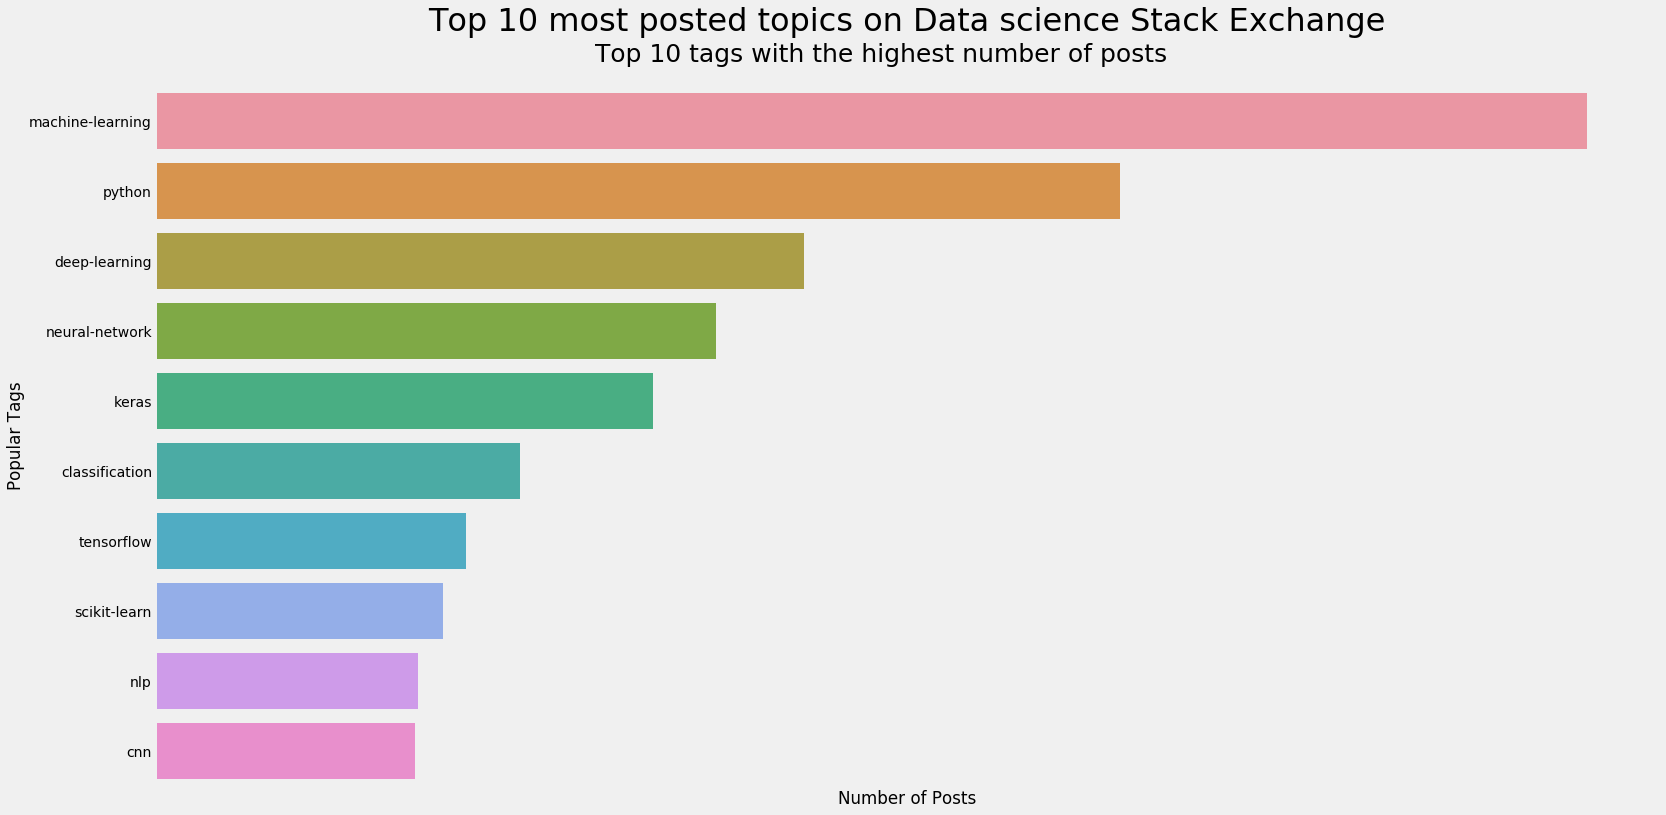

In [38]:
df_tags.sort_values(by='TagCount',ascending=False,inplace=True)
most_used = df_tags.Tags.iloc[:20]

plt.style.use('fivethirtyeight')
plt.figure(figsize=(24,12))
sns.barplot(y=df_tags.Tags.iloc[0:10],x=df_tags.TagCount.iloc[0:10])
plt.ylabel("Popular Tags")
plt.xlabel("Number of Posts")
plt.xticks([],rotation=15)
plt.title("Top 10 most posted topics on Data science Stack Exchange",fontsize=32,y=1.07)
plt.suptitle('Top 10 tags with the highest number of posts',y=0.93, fontsize = 25)
plt.show()

The *ViewCount* similar shows the most popular tags with respect to the number of views recieved to the posts tagged. The plot below gives a relative comparision between the top 10 most viewed topics (tags) on the Data science Stack Exchange server.

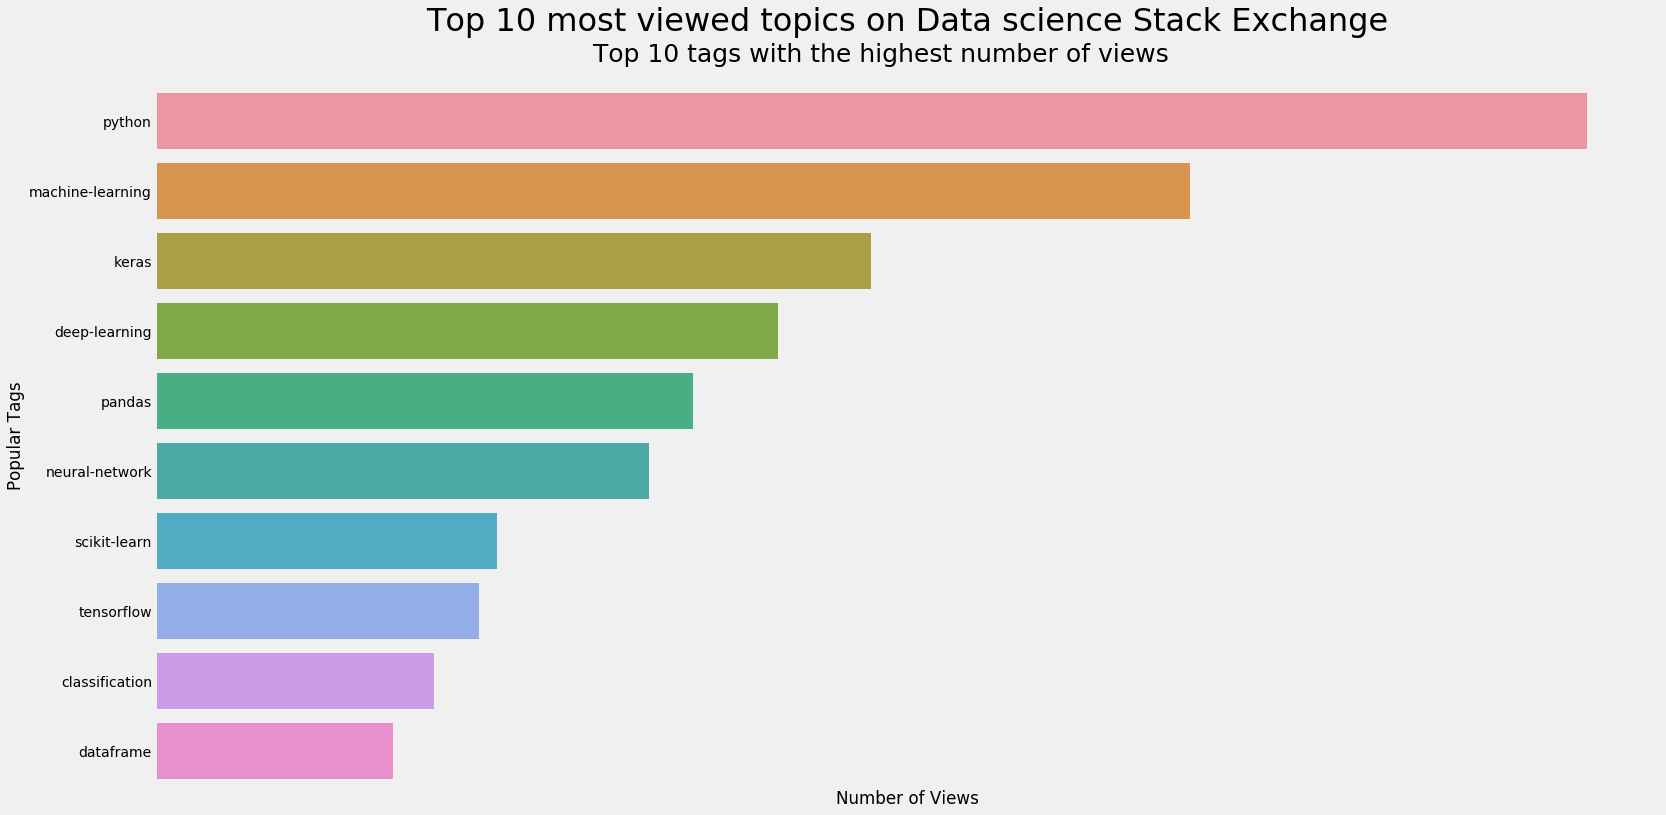

In [35]:
df_tags.sort_values(by='ViewCount',ascending=False,inplace=True)
most_viewed = df_tags.Tags.iloc[:20]

plt.figure(figsize=(24,12))
sns.barplot(y=df_tags.Tags.iloc[0:10],x=df_tags.ViewCount.iloc[0:10])
plt.ylabel("Popular Tags")
plt.xlabel("Number of Views")
plt.xticks([],rotation=45)
plt.title("Top 10 most viewed topics on Data science Stack Exchange",fontsize=32,y=1.07)
plt.suptitle('Top 10 tags with the highest number of views',y=0.93, fontsize = 25)
plt.show()

The two plots above give the most popular tags in terms of number of views amassed or the number of questions posted with that tag. Between the two groups, there are common tags. These common tags are ultimately the most popular tags on the Data science Stack Exchange server. They have high views and high number of posts.

NOTE : The plot shows the top 10 popular tags for both criteria, but for the intersection, the top 20 tags are considered, to increase the resulting set.

In [39]:
popular_tags = np.intersect1d(most_used,most_viewed)
print(popular_tags)

['classification' 'clustering' 'cnn' 'dataset' 'deep-learning' 'keras'
 'lstm' 'machine-learning' 'neural-network' 'nlp' 'pandas' 'python'
 'regression' 'scikit-learn' 'tensorflow' 'time-series']


Between the two segments there are 16 common tags. These tags are the most popular tags :-<br>

    * classification      * clustering       * cnn            * dataset
    * deep-learning       * keras            * lstm           * machine-learning
    * neural-network      * nlp              * pandas         * python
    * regression          * scikit-learn     * tensorflow     * time-series

The popular tags mostly belong to a common topic. Based on the dataset, relations between these tags can be discovered to better understand which pairs or sets of tags are widely popular and thus which segment of data science is widely popular in terms of questions on the server.<br>

One method is to make all possible pairs from the popular tags and make a table with the pair's Tag counts and View counts. This results in a popularity index as done for the single tags.<br>
The pairs are combinations of the popular tags and not the entire tags list, because based on the assumption that the top 10 are the most frequent and rest are not, The rest of the pairs can be eliminated via Upward Closure property from Data Mining concepts.<br>

Similar to previous steps, two functions are coded. The `count_pair()` function returns the number of times the pair of tags have appeared together in the questions posted. The `count_pair_views()` function returns the number of views amassed by posts tagged with the pair. The popular pair of tags will be the intersection of the two i.e. pair of tags having high number of posts as well as high number of views.

In [42]:
pair_tags = list(combinations(popular_tags,2))
pair_tag_count = {}

def count_pair(tags,data):
    ctr=0
    for row in data['Tags']:
        if set(tags).issubset(row):
            ctr+=1
    return ctr

def count_pair_views(tags,data):
    ctr=0
    for row in data[['Tags','ViewCount']].iterrows():
        if set(tags).issubset(row[1]['Tags']):
            ctr+=row[1]['ViewCount']
    return ctr

for tags in pair_tags:
    pair_tag_count[tags] = [count_pair(tags,df),count_pair_views(tags,df)]
    
df_pair_tags = pd.DataFrame.from_dict(pair_tag_count,orient='index').reset_index()
df_pair_tags.columns = ['Tags','TagCount','ViewCount']
df_pair_tags.head(5)

,Tags,TagCount,ViewCount
0,"(classification, clustering)",12,1532
1,"(classification, cnn)",20,1096
2,"(classification, dataset)",28,1991
3,"(classification, deep-learning)",59,35105
4,"(classification, keras)",58,37610


In [43]:
df_pair_tags.sort_values(by='TagCount',ascending=False,inplace=True)
most_used_pair = df_pair_tags.Tags.iloc[:10]

df_pair_tags.sort_values(by='ViewCount',ascending=False,inplace=True)
most_viewed_pair = df_pair_tags.Tags.iloc[:10]

The initial tags were the most popular individually. Making combinations from them, the resulting dataframe was created. For every pair of tags, the dataframe shows the number of posts tagged with that pair and total number of views amassed. Since the initial set was of popular tags, the resulting pairs of popular tags represent association between the two tags forming the pair.

In [44]:
popular_tags_pair = np.intersect1d(most_used_pair,most_viewed_pair)
popular_tags_pair

array([('deep-learning', 'keras'), ('deep-learning', 'machine-learning'),
       ('deep-learning', 'neural-network'), ('keras', 'neural-network'),
       ('keras', 'python'), ('keras', 'tensorflow'),
       ('machine-learning', 'neural-network'),
       ('machine-learning', 'python'), ('pandas', 'python')], dtype=object)

The popular pair of tags as a result of the above analysis are :-

    * deep-learning : keras                 
    * deep-learning : machine-learning       
    * deep-learning : neural-network
    * keras : neural-network                
    * keras : python                         
    * keras : tensorflow
    * machine-learning : neural-netowork    
    * machine-learning : python              
    * pandas : python

The concept used above was nothing but finding frequent item sets of Data mining, or in this case popular item sets. The next step in the algorithm would be to make triplets from these popular pairs. This would represent associativity between three tags.<br>
The possible triplets that can be formed as a combination of the above popular pairs are :-

* deep-learning : keras : neural-network
* deep-learning : machine-learning : neural-network
* machine-learning : python : keras

NOTE : The triplets formed are not all the possible triplets. They are pruned based on the logic - A triplet is formed if and only if all pairs formed from the triplets are part of the set of pairs from which the triplets are derived.

For the first part of the analysis the following conclusions are drawn :-

* More generally, tags representing *predictive analysis* are more popular on the Data science community of the Stack Exchange server as compared to the Descriptive analysis or visualization part of Data science field.
* The following tags are associated to each other and popular across the Data science community on Stack Exchange server,

    * deep-learning
    * machine-learning
    * neural-networks
    * keras

The next part of the analysis is to discover the trend in popularity of deep-learning over the years and to answer the question :-

* Would it benefit the community to post on Deep learning?
* What other topics can be paired with Deep learning for the posts?

A different dataset has been downloaded for this purpose. Instead of just having questions from the year 2019. All questions across all years are present.

In [3]:
df = pd.read_csv('all_questions.csv',parse_dates=True)
df.head(5)

,Id,CreationDate,Tags
0,45416,2019-02-12 00:36:29,<python><keras><tensorflow><cnn><probability>
1,45418,2019-02-12 00:50:39,<neural-network>
2,45422,2019-02-12 04:40:51,<python><ibm-watson><chatbot>
3,45426,2019-02-12 04:51:49,<keras>
4,45427,2019-02-12 05:08:24,<r><predictive-modeling><machine-learning-mode...


The dataset contains only 3 columns as compared to the dataset used previously. Both the datasets are of the same Posts table from the open database provided by Stack Exchange.

    * Id - id of the posted question
    * CreationDate - date the question was posted
    * Tags - tags associated with the post

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21576 entries, 0 to 21575
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Id            21576 non-null  int64 
 1   CreationDate  21576 non-null  object
 2   Tags          21576 non-null  object
dtypes: int64(1), object(2)
memory usage: 505.8+ KB


A similar approach, as done previously, to clean the tags column for ease of the analysis.
* All chevrons are removed from the tags column.
* The tags are converted to lists for ease of usage

In [5]:
df.Tags = df.Tags.str.replace("><",",")
df.Tags = df.Tags.str.replace("[<>]","")
df.Tags = df.Tags.str.split(",")

The purpose is to find the general trend deep learning has witnessed over time. The *CreationDate* holds granular information regarding the questions posted. Since the aim is to only find the trend, year extracted from *CreationDate* would suffice.

In [6]:
df.CreationDate = pd.to_datetime(df.CreationDate)
df['Year'] = df.CreationDate.dt.year

Posts containing the deep-learning tag are relevant to the analysis. A new column *is_dl* is created to identify which posts are tagged as deep-learning.

In [7]:
df['is_dl'] = df.Tags.apply(
    lambda x: 1 if 'deep-learning' in x else 0
)

The posts have been identified as relevant or not and the years have been extracted from *CreationDate*.<br>
From these results, two groupings are made. Group 1, groups on the *Year* column and aggregates the size. In short group 1 indicates the number of questions posted on Data science Stack Exchange server for the years.
Group 2, groups on the *Year* column, for only those questions that were tagged as deep-learning, and aggregated on size. Thus group 2 indicates the number of questions posted as deep-learning on Data science Stack Exchange for the years.<br>

Both these groupings are comibined using the `pd.merge()` function. The resulting dataframe gives us the statistic on the number of questions posted as deep-learning vs number of questions in total posted for the years. 

In [8]:
grouped_1 = df.groupby(by=['Year'])
grouped_2 = df[df.is_dl == 1].groupby(by=['Year'])

temp_1 = pd.DataFrame(grouped_2.size(),columns=['DL_posts']).reset_index()
temp_2 = pd.DataFrame(grouped_1.size(),columns=['Total']).reset_index()

df_posts = pd.merge(temp_1,temp_2,left_on=['Year'],right_on=['Year'],how='inner')
df_posts

,Year,DL_posts,Total
0,2014,8,562
1,2015,30,1167
2,2016,157,2146
3,2017,425,2957
4,2018,902,5475
5,2019,1216,8810
6,2020,67,459


Dividing the columns *DL_posts* and *Total* gives the proportion of posts posted as deep-learning as compared to total posts for that year. These proportions can be used to visualize the trend in the number of posts tagged deep-learning through the years.

In [9]:
df_posts['Percentage'] = (df_posts.DL_posts/df_posts.Total) * 100
df_posts.set_index('Year',inplace=True)
df_posts

,DL_posts,Total,Percentage
Year,,,
2014,8,562,1.423488
2015,30,1167,2.570694
2016,157,2146,7.315937
2017,425,2957,14.372675
2018,902,5475,16.474886
2019,1216,8810,13.802497
2020,67,459,14.596950


The table clearly showcases an upward trend in the number of posts tagged as deep-learning. The year 2020 has seen less posts as it is the current year, hence is excluded from the analysis. The plot below visualizes the trend shown in the table for better understanding.

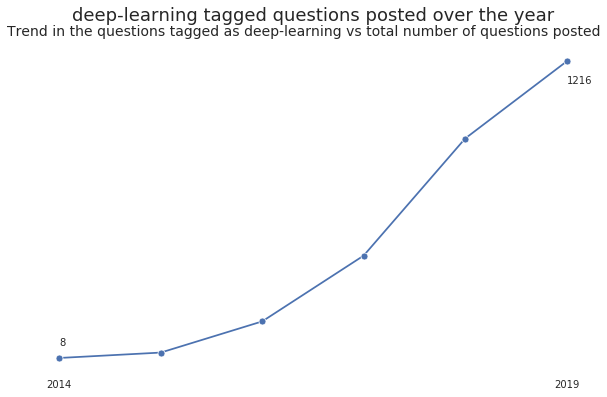

In [11]:
plt.style.use('seaborn')
sns.set_style('white')

plt.figure(figsize=(10,6))
sns.lineplot(x=df_posts.index[:-1],y=df_posts.iloc[:-1].DL_posts, markers="o",style=True, legend=False)
plt.xlabel("")
plt.ylabel("")
plt.title("deep-learning tagged questions posted over the year",fontsize=18,loc='center',y=1.06)
plt.suptitle("Trend in the questions tagged as deep-learning vs total number of questions posted",y=0.93,fontsize=14)
plt.tick_params(left=False,bottom=False)
plt.yticks([])
plt.xticks([2014,2019])
plt.text(max(df_posts.index[:-1]),max(df_posts.DL_posts)-90,max(df_posts.DL_posts))
plt.text(min(df_posts.index[:-1]),min(df_posts.DL_posts)+50,min(df_posts.DL_posts))
plt.show()

The visualization confirms the trend shown in the table. The following conclusions are drawn from the plot :-
* Every year since 2014 there has been an upward trend (increase) in the number of questions tagged as deep-learning.
* Over the years (between 2014 and 2019) there has been a 12% increase in the posts (questions) tagged as deep-learning.

From the previous analysis, it was found that Deep Learning was associated with other tags such as :-

* keras
* machine-learning
* neural-networks
* tensorflow

From these four tags, Neural networks is the underlying technology of Deep Learning, similarly, Keras and Tensorflow are frameworks built to support and implement deep learning. These three tags are highly associated to Deep Learning. Even though Machine Learning and Deep Learning intersect, Machine Learning consists of topics out of scope for Deep Learning.<br>

By this logic, the assumption is made that any post containing either of these tags,

* deep-learning
* keras
* neural-network
* tensorflow

is in general labeled as relevant to the topic and hence the post is categorized as a Deep Learning question.<br>
A new column is created, *is_relevant*, to indicate the above. 

In [12]:
relevant_tags = ['deep-learning','keras','tensorflow','neural-network']

df['is_relevant'] = df.Tags.apply( 
    lambda x: 1 if list(np.intersect1d(x,relevant_tags)) else 0 
)

Similar to the previous logic, the grouping will happen based on years and aggregate on relevance of the post indicated by *is_relevant*.

In [13]:
grouped_1 = df.groupby(by=['Year'])
grouped_2 = df[df.is_relevant == 1].groupby(by=['Year'])

temp_1 = pd.DataFrame(grouped_2.size(),columns=['DL_posts']).reset_index()
temp_2 = pd.DataFrame(grouped_1.size(),columns=['Total']).reset_index()

df_posts = pd.merge(temp_1,temp_2,left_on=['Year'],right_on=['Year'],how='inner')
df_posts

,Year,DL_posts,Total
0,2014,30,562
1,2015,114,1167
2,2016,417,2146
3,2017,883,2957
4,2018,1876,5475
5,2019,2695,8810
6,2020,130,459


Dividing the columns DL_posts and Total gives the proportion of posts relevant to the analysis as compared to total posts for that year. These proportions can be used to visualize the trend in the number of posts relevant through the years. 

NOTE : A relevant post here means that the tag on the post is atleast one of the above 4 concluded tags. 

In [14]:
df_posts['Percentage'] = (df_posts.DL_posts/df_posts.Total) * 100
df_posts.set_index('Year',inplace=True)
df_posts

,DL_posts,Total,Percentage
Year,,,
2014,30,562,5.338078
2015,114,1167,9.768638
2016,417,2146,19.431500
2017,883,2957,29.861346
2018,1876,5475,34.264840
2019,2695,8810,30.590238
2020,130,459,28.322440


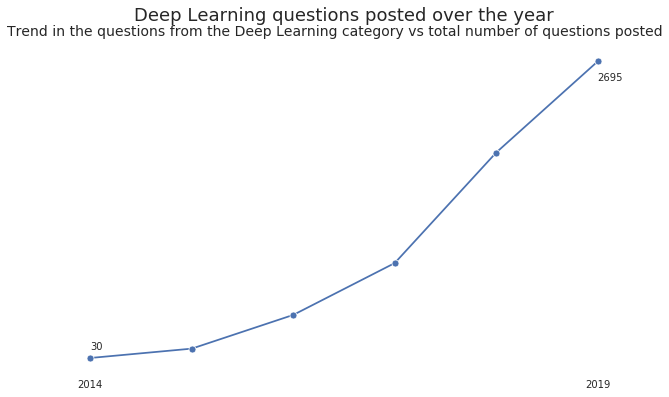

In [15]:
plt.style.use('seaborn')
sns.set_style('white')

plt.figure(figsize=(10,6))
sns.lineplot(x=df_posts.index[:-1],y=df_posts.iloc[:-1].DL_posts, markers="o",style=True, legend=False)
plt.xlabel("")
plt.ylabel("")
plt.title("Deep Learning questions posted over the year",fontsize=18,loc='center',y=1.06)
plt.suptitle("Trend in the questions from the Deep Learning category vs total number of questions posted",y=0.93,fontsize=14)
plt.tick_params(left=False,bottom=False)
plt.yticks([])
plt.xticks([2014,2019])
plt.text(max(df_posts.index[:-1]),max(df_posts.DL_posts)-170,max(df_posts.DL_posts))
plt.text(min(df_posts.index[:-1]),min(df_posts.DL_posts)+70,min(df_posts.DL_posts))
plt.show()

The following inferences are made from the plot :-

* Similar to previous plot, there exists an upward trend in number of questions posted on Deep Learning category.
* From the year 2014 to 2019, posts on Deep Learning category have seen a 25% increase.

The conclusion, gathered from the project are :-

* The following topics (tags) are most popular in the Data science community on Stack Exchange,

        * classification      * clustering       * cnn            * dataset
        * deep-learning       * keras            * lstm           * machine-learning
        * neural-network      * nlp              * pandas         * python
        * regression          * scikit-learn     * tensorflow     * time-series
        
* Among the most popular topics, there exists association between certain topics such as,
        
        * deep-learning : keras : neural-network
        * deep-learning : machine-learning : neural-network
        * machine-learning : python : keras

* The Deep Learning category consists of the following tags associated with the deep-learning tag,

        * keras       
        * tensorflow
        * neural-networks

* Deep Learning category has seen an upward trend in terms of number of posts since 2014.

* Currently Deep Learning seems to be the most sought after category in the Data science community on Stack Exchange.

* Creating posts related to Deep Learning would widely benefit the community and be popular amongst it.